In [1]:
#TimeSeriesNN -- for glitch prediction
#Follows closely https://keras.io/examples/timeseries/timeseries_anomaly_detection/
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from datetime import datetime
from matplotlib import pyplot as plt
from matplotlib import dates as md
'''Uses the Numenta Anomaly Benchmark(NAB) dataset. 
Provides artifical timeseries data containing labeled anomalous 
periods of behavior. Data are ordered, timestamped, single-valued metrics.
-- Note: We must install NAB with conda env create
We plan to use the art_daily_small_noise.csv file for training and the 
art_daily_jumpsup.csv file for testing. 
The simplicity of the NAB dataset allows us to demonstrate anomaly detection effectively.'''

master_url_root = "https://raw.githubusercontent.com/numenta/NAB/master/data/"
#master_url_root = "C:/users/rongrisell/Project/Resusc/NAB-master/NAB-master/data/""

df_small_noise_url_suffix = "artificialNoAnomaly/art_daily_small_noise.csv"
df_small_noise_url = master_url_root + df_small_noise_url_suffix
df_small_noise = pd.read_csv(df_small_noise_url)

df_daily_jumpsup_url_suffix = "artificialWithAnomaly/art_daily_jumpsup.csv"
df_daily_jumpsup_url = master_url_root + df_daily_jumpsup_url_suffix
df_daily_jumpsup = pd.read_csv(df_daily_jumpsup_url)

In [8]:
# look at the data
print(df_small_noise.head())

print(df_daily_jumpsup.head())
def plot_dates_values(data):
    dates = data["timestamp"].to_list()
    values = data["value"].to_list()
    dates = [datetime.strptime(x, "%Y-%m-%d %H:%M:%S") for x in dates]
    plt.subplots_adjust(bottom=0.2)
    plt.xticks(rotation=25)
    ax = plt.gca()
    xfmt = md.DateFormatter("%Y-%m-%d %H:%M:%S")
    ax.xaxis.set_major_formatter(xfmt)
    plt.plot(dates, values)
    plt.show()

             timestamp      value
0  2014-04-01 00:00:00  18.324919
1  2014-04-01 00:05:00  21.970327
2  2014-04-01 00:10:00  18.624806
3  2014-04-01 00:15:00  21.953684
4  2014-04-01 00:20:00  21.909120
             timestamp      value
0  2014-04-01 00:00:00  19.761252
1  2014-04-01 00:05:00  20.500833
2  2014-04-01 00:10:00  19.961641
3  2014-04-01 00:15:00  21.490266
4  2014-04-01 00:20:00  20.187739


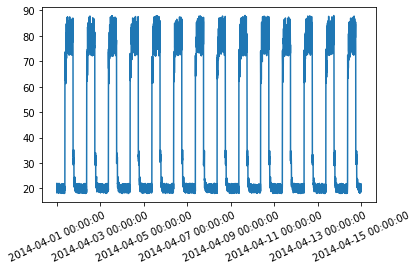

'/usr/local/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.\nTo register the converters:\n    >>> from pandas.plotting import register_matplotlib_converters\n    >>> register_matplotlib_converters()\n  warnings.warn(msg, FutureWarning)'

In [9]:
#Timeseries data without anomalies
#Use the following data for training:
plot_dates_values(df_small_noise)
'''/usr/local/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: 
FutureWarning: Using an implicitly registered datetime converter for a 
matplotlib plotting method. The converter was registered by pandas on import. 
Future versions of pandas will require you to explicitly register matplotlib converters.
To register the converters:
    >>> from pandas.plotting import register_matplotlib_converters
    >>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)'''

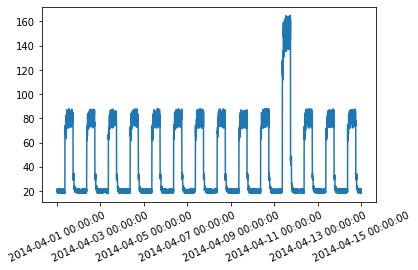

In [10]:
#Timeseries data with anomalies
#Use the following data for testing and see if the sudden jump up in the data is detected as an anomaly.
plot_dates_values(df_daily_jumpsup)

In [11]:
# Prepare training data
'''Get data values from the training timeseries data file and 
normalize the value data. We have a value for every 5 mins for 14 days.
24 * 60 / 5 = 288 timesteps per day
288 * 14 = 4032 data points in total'''
def get_value_from_df(df):
    return df.value.to_list()

def normalize(values):
    mean = np.mean(values)
    values -= mean
    std = np.std(values)
    values /= std
    return values, mean, std

# Get the `value` column from the training dataframe.
training_value = get_value_from_df(df_small_noise)

# Normalize `value` and save the mean and std we get,
# for normalizing test data.

training_value, training_mean, training_std = normalize(training_value)
len(training_value)

#Create sequences combining TIME_STEPS contiguous data values from the training data.
TIME_STEPS = 288

def create_sequences(values, time_steps=TIME_STEPS):
    output = []
    for i in range(len(values) - time_steps):
        output.append(values[i : (i + time_steps)])
    # Convert 2D sequences into 3D as we will be feeding this into
    # a convolutional layer.
    return np.expand_dims(output, axis=2)

x_train = create_sequences(training_value)
print("Training input shape: ",x_train.shape)

'''ValueError: A target array with shape (3744, 288, 1) was passed for an output of 
shape (None, 1152, 1) while using as loss `mean_squared_error`. This loss expects 
targets to have the same shape as the output.  

24 * 60 / 5 = 288 timesteps per day
288 * 14 = 4032 data points in total
I added:'''

#x_train = x_train.reshape(3744, 288, 1).astype("float32") / 255
#x_test = x_test.reshape(3744, 288, 1).astype("float32") / 255

# WHERE IS x-test?????????
#y_train = y_train.astype("float32")
#y_test = y_test.astype("float32")
#WHAT IS y_train etc.?????

Training input shape:  (3744, 288, 1)


'ValueError: A target array with shape (3744, 288, 1) was passed for an output of \nshape (None, 1152, 1) while using as loss `mean_squared_error`. This loss expects \ntargets to have the same shape as the output.  \n\n24 * 60 / 5 = 288 timesteps per day\n288 * 14 = 4032 data points in total\nI added:'

In [12]:
#Build a model
'''This is a convolutional reconstruction autoencoder model. 
The model will take input of shape (batch_size, sequence_length, num_features) 
and return output of the same shape. 
In this case, sequence_length is 288 and num_features is 1.'''

#This patches up the missing Conv1DTranspose - Grisell had to write this:
class Conv1DTranspose(tf.keras.layers.Layer):
    def __init__(self, filters, kernel_size, strides=1, padding='valid'):
        super().__init__()
        self.conv2dtranspose = tf.keras.layers.Conv2DTranspose(
          filters, (kernel_size, 1), (strides, 1), padding
        )
    def call(self, x):
        x = tf.expand_dims(x, axis=2)
        x = self.conv2dtranspose(x)
        x = tf.squeeze(x, axis=2)
        return x
# Why TensorFlow didn't implement this, no one knows!!!

model = keras.Sequential(
    [
        layers.Input(shape=(x_train.shape[1], x_train.shape[2])),
        layers.Conv1D(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1D(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        Conv1DTranspose(
           filters=16, kernel_size=7, padding="same", strides=2 
        ),
        layers.Dropout(rate=0.2),
        Conv1DTranspose(
           filters=32, kernel_size=7, padding="same", strides=2
        ),
        Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
    ]
)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 144, 32)           256       
_________________________________________________________________
dropout (Dropout)            (None, 144, 32)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 72, 32)            7200      
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 144, 16)           3600      
_________________________________________________________________
dropout_1 (Dropout)          (None, 144, 16)           0         
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 288, 32)           3616      
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 288, 1)            2

In [13]:
#Train the model
#Please note that we are using x_train as both the input and the target since 
#this is a reconstruction model.
history = model.fit(
    x_train,
    x_train,
    epochs=50,
    batch_size=128,
    validation_split=0.1,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
)

Train on 3369 samples, validate on 375 samples
Epoch 1/50
3369/3369 [==============================] - 3s 859us/sample - loss: 0.3251 - val_loss: 0.0512
Epoch 2/50
3369/3369 [==============================] - 2s 493us/sample - loss: 0.0651 - val_loss: 0.0387
Epoch 3/50
3369/3369 [==============================] - 2s 477us/sample - loss: 0.0490 - val_loss: 0.0286
Epoch 4/50
3369/3369 [==============================] - 2s 491us/sample - loss: 0.0412 - val_loss: 0.0238
Epoch 5/50
3369/3369 [==============================] - 2s 484us/sample - loss: 0.0358 - val_loss: 0.0216
Epoch 6/50
3369/3369 [==============================] - 2s 460us/sample - loss: 0.0324 - val_loss: 0.0200
Epoch 7/50
3369/3369 [==============================] - 2s 462us/sample - loss: 0.0297 - val_loss: 0.0190
Epoch 8/50
3369/3369 [==============================] - 2s 452us/sample - loss: 0.0275 - val_loss: 0.0169
Epoch 9/50
3369/3369 [==============================] - 2s 489us/sample - loss: 0.0257 - val_loss: 0.0157

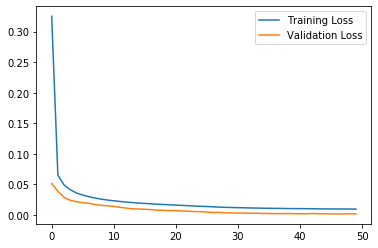

In [14]:
#Plot training and validation loss to see how the training went.
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

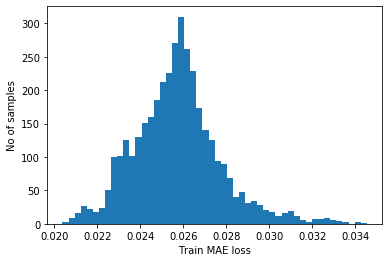

Reconstruction error threshold:  0.03453748444556303


In [15]:
#Detecting anomalies
'''We will detect anomalies by determining how well our model can reconstruct the input data.
1. Find MAE loss on training samples.
2. Find max MAE loss value. This is the worst our model has performed trying to reconstruct a sample. We will make this the threshold for anomaly detection.
3. If the reconstruction loss for a sample is greater than this threshold value then we can infer that the model is seeing a pattern that it isn't familiar with. We will label this sample as an anomaly.'''
# Get train MAE loss.
x_train_pred = model.predict(x_train)
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)


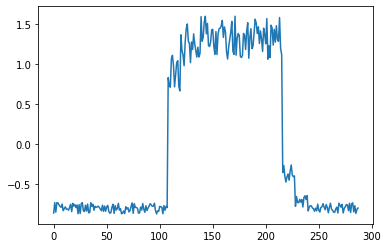

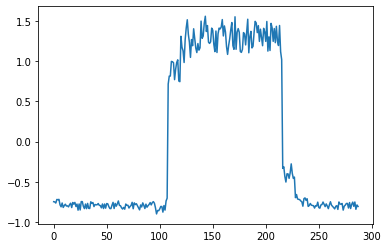

In [16]:
#Compare recontruction
#See how our model has recontructed the first sample. This is the 288 timesteps from day 1 of our training dataset.
# Checking how the first sequence is learnt
plt.plot(x_train[0])
plt.show()
plt.plot(x_train_pred[0])
plt.show()

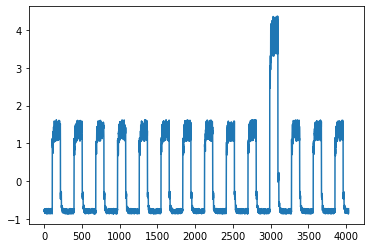

In [17]:
#Prepare test data
def normalize_test(values, mean, std):
    values -= mean
    values /= std
    return values


test_value = get_value_from_df(df_daily_jumpsup)
test_value = normalize_test(test_value, training_mean, training_std)
plt.plot(test_value.tolist())
plt.show()

Test input shape:  (3744, 288, 1)


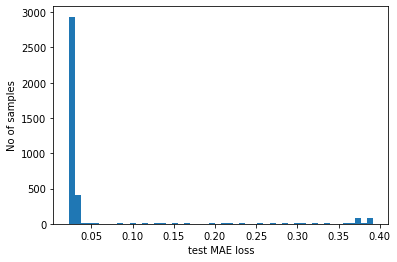

Number of anomaly samples:  409
Indices of anomaly samples:  (array([ 213,  394,  398, 1653, 1654, 1655, 1834, 2121, 2518, 2696, 2697,
       2698, 2699, 2701, 2702, 2703, 2704, 2705, 2706, 2707, 2708, 2709,
       2710, 2711, 2712, 2713, 2714, 2715, 2716, 2717, 2718, 2719, 2720,
       2721, 2722, 2723, 2724, 2725, 2726, 2727, 2728, 2729, 2730, 2731,
       2732, 2733, 2734, 2735, 2736, 2737, 2738, 2739, 2740, 2741, 2742,
       2743, 2744, 2745, 2746, 2747, 2748, 2749, 2750, 2751, 2752, 2753,
       2754, 2755, 2756, 2757, 2758, 2759, 2760, 2761, 2762, 2763, 2764,
       2765, 2766, 2767, 2768, 2769, 2770, 2771, 2772, 2773, 2774, 2775,
       2776, 2777, 2778, 2779, 2780, 2781, 2782, 2783, 2784, 2785, 2786,
       2787, 2788, 2789, 2790, 2791, 2792, 2793, 2794, 2795, 2796, 2797,
       2798, 2799, 2800, 2801, 2802, 2803, 2804, 2805, 2806, 2807, 2808,
       2809, 2810, 2811, 2812, 2813, 2814, 2815, 2816, 2817, 2818, 2819,
       2820, 2821, 2822, 2823, 2824, 2825, 2826, 2827, 2828, 2

In [18]:
# Create sequences from test values.
x_test = create_sequences(test_value)
print("Test input shape: ", x_test.shape)

# Get test MAE loss.
x_test_pred = model.predict(x_test)
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)
test_mae_loss = test_mae_loss.reshape((-1))

plt.hist(test_mae_loss, bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.show()

# Detect all the samples which are anomalies.
anomalies = (test_mae_loss > threshold).tolist()
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))

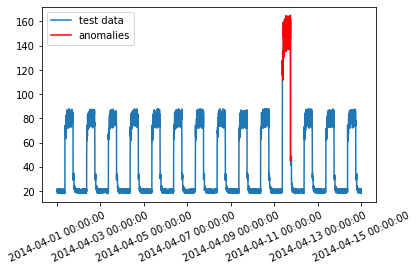

In [19]:
#Plot anomalies
'''We now know the samples of the data which are anomalies. 
With this, we will find the corresponding timestamps from the 
original test data. We will be using the following method to do that:
Let's say time_steps = 3 and we have 10 training values. 
Our x_train will look like this:
0, 1, 2
1, 2, 3
2, 3, 4
3, 4, 5
4, 5, 6
5, 6, 7
6, 7, 8
7, 8, 9
All except the initial and the final time_steps-1 data values, 
will appear in time_steps number of samples. So, if we know that 
the samples [(3, 4, 5), (4, 5, 6), (5, 6, 7)] are anomalies, 
we can say that the data point 5 is an anomaly.
#data i is an anomaly if samples [(i - timesteps + 1) to (i)] are anomalies'''

anomalous_data_indices = []
for data_idx in range(TIME_STEPS - 1, len(test_value) - TIME_STEPS + 1):
    time_series = range(data_idx - TIME_STEPS + 1, data_idx)
    if all([anomalies[j] for j in time_series]):
        anomalous_data_indices.append(data_idx)
#Overlay the anomalies on the original test data plot.
df_subset = df_daily_jumpsup.iloc[anomalous_data_indices, :]
plt.subplots_adjust(bottom=0.2)
plt.xticks(rotation=25)
ax = plt.gca()
xfmt = md.DateFormatter("%Y-%m-%d %H:%M:%S")
ax.xaxis.set_major_formatter(xfmt)

dates = df_daily_jumpsup["timestamp"].to_list()
dates = [datetime.strptime(x, "%Y-%m-%d %H:%M:%S") for x in dates]
values = df_daily_jumpsup["value"].to_list()
plt.plot(dates, values, label="test data")

dates = df_subset["timestamp"].to_list()
dates = [datetime.strptime(x, "%Y-%m-%d %H:%M:%S") for x in dates]
values = df_subset["value"].to_list()
plt.plot(dates, values, label="anomalies", color="r")

plt.legend()
plt.show()